In [ ]:
import pandas as pd

weather = pd.read_csv('WeatherData/weather_jfk.csv', index_col="DATE")

In [ ]:
weather

In [ ]:
# weather = weather.loc['1985':]
weather


filtered for newer data than 1985, so that i get more non null columns

In [ ]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]

In [ ]:
null_pct

removing the data where the null percentage is more than 5% in order to clean the data

In [ ]:
valid_columns = weather.columns[null_pct < 0.05]

In [ ]:
valid_columns

In [ ]:
weather = weather[valid_columns].copy()

In [ ]:
weather.columns = weather.columns.str.lower()

In [ ]:
weather

In [ ]:
weather.apply(pd.isnull).sum()

In [ ]:
weather.ffill(inplace=True)

replacing all missing values with a value from the previous row, so that the data is continuous

In [ ]:
weather.apply(pd.isnull).sum()

In [ ]:
weather.dtypes

In [ ]:
weather.index

In [ ]:
weather.index = pd.to_datetime(weather.index)

changing the index data type to data 

In [ ]:
weather.index.year.value_counts().sort_index()

In [ ]:
weather['tmax'].plot()

In [ ]:
weather["target"] = weather.shift(-1)["tmax"]
weather

In [ ]:
weather = weather.ffill()
weather

In [ ]:
numeric_columns = weather.select_dtypes(include=["float", "int"]).columns
weather[numeric_columns].corr()


In [ ]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

In [ ]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i, :]
        test = weather.iloc[i:(i+step), :]

        model.fit(train[predictors], train["target"])

        predictions = model.predict(test[predictors])

        predictions = pd.Series(predictions, index=test.index)
        combined = pd.concat([test["target"], predictions], axis=1)

        combined.columns = ["actual", "predicted"]

        combined["diff"] = (combined["actual"] - combined["predicted"]).abs()

        all_predictions.append(combined)

    return pd.concat(all_predictions)


In [ ]:
predictions = backtest(weather, rr, predictors)
predictions

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions["actual"], predictions["predicted"])

In [ ]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(weather, horizon, col):
    label = f"rolling_{horizon}_{col}"

    weather[label] = weather[col].rolling(horizon).mean()
    weather[f"{label}_pct"] = pct_diff(weather[label], weather[col])

    return weather

rolling_horizons = [3, 14]

for horizon in rolling_horizons:
    for col in ["tmax", "tmin", "prcp"]:
        weather = compute_rolling(weather, horizon, col)

weather

In [ ]:
weather = weather.iloc[14:, :]
weather

In [ ]:
weather = weather.fillna(0)

In [ ]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["tmax", "tmin", "prcp"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day, group_keys=False).apply(expand_mean)
    

weather

In [ ]:
predictors = weather.columns[~weather.columns.isin(["target", "name", "station"])]
predictors

In [ ]:
predictions = backtest(weather, rr, predictors)
predictions

mean_absolute_error(predictions["actual"], predictions["predicted"])



In [ ]:
predictions.sort_values("diff", ascending=False)

In [ ]:
weather.loc["1990-03-07":"1990-03-17"]

In [ ]:
predictions["diff"].round().value_counts().sort_index().plot()

try xgboost, lightgbm, catboost, and random forest to see which one is the best

-- XGBOOST SECTION --

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(weather[predictors], weather["target"], test_size=0.2, random_state=42)

In [85]:
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

pipe = Pipeline([
    ("target_encoder", TargetEncoder()),
    ("xgb", XGBRegressor())
])
pipe.fit(X_train, y_train)



Pipeline(steps=[('target_encoder', TargetEncoder(cols=[])),
                ('xgb',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [86]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, pipe.predict(X_test))



4.974245447933133

In [90]:
from sklearn.model_selection import GridSearchCV

param_grid = {"xgb__n_estimators": [100, 200, 300], "xgb__max_depth": [3, 5, 7], "xgb__learning_rate": [0.01, 0.1, 0.3]}

grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_params_)

# output is: {'xgb__max_depth': 3, 'xgb__n_estimators': 100}

mean_absolute_error(y_test, grid.predict(X_test))

{'xgb__max_depth': 3, 'xgb__n_estimators': 100}


4.829119264476494

In [91]:
import joblib

joblib.dump(grid, "weather_model.pkl")

# to load the model

model = joblib.load("weather_model.pkl")

model.predict(X_test)

model.best_params_

model.best_score_

model.best_estimator_

model.best_estimator_.named_steps["xgb"].feature_importances_

array([0.00185246, 0.00478687, 0.00103687, 0.21039923, 0.441021  ,
       0.00806464, 0.00176389, 0.00160741, 0.00437127, 0.00418142,
       0.00213822, 0.18487807, 0.00237024, 0.00309053, 0.00139937,
       0.00151137, 0.00212841, 0.10080205, 0.00115143, 0.01699545,
       0.00145362, 0.00154827, 0.00144783], dtype=float32)

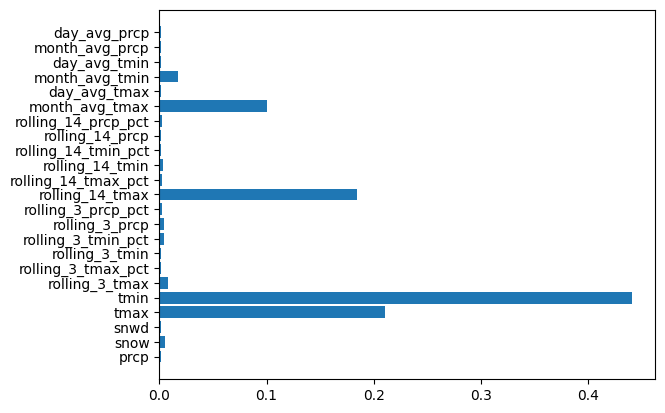

In [92]:
import matplotlib.pyplot as plt

plt.barh(X_train.columns, model.best_estimator_.named_steps["xgb"].feature_importances_)
plt.show()